<a href="https://colab.research.google.com/github/mohsenfayyaz/edge-probe/blob/main/Edge_Probing_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations & Imports

In [2]:
! nproc
! lscpu
! nvidia-smi

2
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_s

In [3]:
! git clone https://github.com/mohsenfayyaz/edge-probing-datasets.git
! pip install datasets
! pip install transformers

Cloning into 'edge-probing-datasets'...
remote: Enumerating objects: 1280, done.
remote: Total 1280 (delta 0), reused 0 (delta 0), pack-reused 1280
Receiving objects: 100% (1280/1280), 71.20 MiB | 25.32 MiB/s, done.
Resolving deltas: 100% (402/402), done.
Checking out files: 100% (1251/1251), done.
     |████████████████████████████████| 194kB 7.4MB/s 
     |████████████████████████████████| 245kB 12.5MB/s 
     |████████████████████████████████| 112kB 15.3MB/s 
     |████████████████████████████████| 2.0MB 7.7MB/s 
     |████████████████████████████████| 3.2MB 37.0MB/s 
     |████████████████████████████████| 890kB 54.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=ff4bd3f331e8c04f6603d872cd636875e8b67c3381524a3156ff9654525c6d60
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
from tqdm.notebook import tqdm
import pandas as pd
from IPython.display import display
import torch
import numpy as np
import shutil
import os
import datasets
import json
import gc
import datetime
import torch.nn as nn
from abc import ABC, abstractmethod
import torch.optim as optim
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.metrics import f1_score

# Configs

In [5]:
class Dataset_info:
    def __init__(self, dataset_name, num_of_spans, max_span_length=3):
        self.dataset_name = dataset_name
        self.num_of_spans = num_of_spans
        self.max_span_length = max_span_length

In [6]:
# model_checkpoint = 'xlnet-base-cased'
# model_checkpoint = "xlnet-large-cased"
model_checkpoint = "bert-base-cased"
# model_checkpoint = "bert-large-cased"
# model_checkpoint = "albert-xxlarge-v2"
# model_checkpoint = "t5-small"
# model_checkpoint ="t5-large"
# model_checkpoint = "mohsenfayyaz/toxicity-classifier"


my_dataset_info = Dataset_info("dpr", num_of_spans=2)
# my_dataset_info = Dataset_info("ud", num_of_spans=2)

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

# Prepare Dataset & Spans

In [7]:
from transformers import AutoTokenizer, AutoModel
  
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
  
model = AutoModel.from_pretrained(model_checkpoint)

In [8]:
class Utils:
    def one_hot(idx, length):
        o = np.zeros(length, dtype=np.int8)
        o[idx] = 1
        return o

In [9]:
class Dataset_handler:
    def __init__(self, dataset_info: Dataset_info):
        self.dataset = datasets.DatasetDict()
        self.tokenized_dataset = None
        self.dataset_info = dataset_info
        self.labels_list = None

        if dataset_info.dataset_name == "dpr":
            self.json_to_dataset('./edge-probing-datasets/data/dpr_data/train.json', data_type="train")
            self.json_to_dataset('./edge-probing-datasets/data/dpr_data/dev.json', data_type="dev")
            self.json_to_dataset('./edge-probing-datasets/data/dpr_data/test.json', data_type="test")
        elif dataset_info.dataset_name == "ud":
            frac = 1
            self.json_to_dataset('./edge-probing-datasets/data/ud_data/en_ewt-ud-train.json', data_type="train", fraction = frac)
            self.json_to_dataset('./edge-probing-datasets/data/ud_data/en_ewt-ud-dev.json', data_type="dev", fraction = frac)
            self.json_to_dataset('./edge-probing-datasets/data/ud_data/en_ewt-ud-test.json', data_type="test", fraction = frac)
        else:
            throw("Error: Unkown dataset name!")

        print("⌛ Tokenizing Dataset")
        self.tokenized_dataset = self.tokenize_dataset(self.dataset)
        print("⌛ Adding One Hot Representation of Labels")
        self.tokenized_dataset = self.one_hot_dataset_labels(self.tokenized_dataset)

    # Public:
    def json_to_dataset(self, json_path, data_type="train", fraction=1):
        data_df = self.json_to_df(json_path)
        # print(data_type, "text max length:", data_df["text"].str.len().max())  # max length of texts
        if fraction != 1:
            data_df = data_df.sample(frac=fraction, random_state=1).sort_index().reset_index(drop=True)
        self.dataset[data_type] = datasets.Dataset.from_pandas(data_df)
        return self.dataset
 
    def tokenize_dataset(self, dataset):
        ### Tokenize and realign the spans based on new parts in the tokenized sentence ###
        tokenized_dataset = dataset.map(tokenize_and_align_spans, batched=False, num_proc=None)
        return tokenized_dataset

    def one_hot_dataset_labels(self, dataset):
        train_df = pd.DataFrame(self.tokenized_dataset["train"]["label"], columns=['label'])
        dev_df = pd.DataFrame(self.tokenized_dataset["dev"]["label"], columns=['label'])
        test_df = pd.DataFrame(self.tokenized_dataset["test"]["label"], columns=['label'])
        self.labels_list = list(set(train_df["label"].unique()).union
                               (set(dev_df["label"].unique())).union
                               (set(test_df["label"].unique())))
        one_hot_dataset = dataset.map(one_hot_label, fn_kwargs={"label_list": self.labels_list} ,batched=False, num_proc=None)
        return one_hot_dataset

    # Private:
    def json_to_df(self, json_path):
        with open(json_path, encoding='utf-8') as file:
            data_list = list()
            for line in file:
                instance = json.loads(line)
                for target in instance["targets"]:
                    data_list.append({"text": instance["text"], 
                                    "span1": target["span1"],
                                    "span2": target["span2"],
                                    "label": target["label"]})
        return pd.DataFrame.from_dict(data_list)

def one_hot_label(examples, **fn_kwargs):
    label_list = fn_kwargs["label_list"]
    examples["one_hot_label"] = Utils.one_hot(label_list.index(examples["label"]), len(label_list))
    return examples

def tokenize_and_align_spans(examples):
    tokenized_inputs = tokenizer(examples["text"])
    # tokenized_inputs = tokenizer(examples["text"], truncation=True, is_split_into_words=True, padding="max_length", max_length=210)
    word_ids = tokenized_inputs.word_ids()
    tokenized_inputs["span1"] = [0, 0]
    tokenized_inputs["span2"] = [0, 0]
    tokenized_inputs["span1"][0] = word_ids.index(examples["span1"][0])  # First occurance
    tokenized_inputs["span1"][1] = len(word_ids) - 1 - word_ids[::-1].index(examples["span1"][1] - 1) + 1  # Last occurance (+1 for open range)
    tokenized_inputs["span2"][0] = word_ids.index(examples["span2"][0])  # First occurance
    tokenized_inputs["span2"][1] = len(word_ids) - 1 - word_ids[::-1].index(examples["span2"][1] - 1) + 1# Last occurance
    return tokenized_inputs

In [10]:
my_dataset_handler = Dataset_handler(my_dataset_info);

⌛ Tokenizing Dataset



⌛ Adding One Hot Representation of Labels


,attention_mask,input_ids,label,one_hot_label,span1,span2,text,token_type_ids
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[101, 1109, 17775, 4860, 1113, 1103, 7366, 127...",not-entailed,"[1, 0]","[8, 9]","[1, 3]",The bee landed on the flower because it had po...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[101, 1109, 17775, 4860, 1113, 1103, 7366, 127...",entailed,"[0, 1]","[8, 9]","[5, 7]",The bee landed on the flower because it had po...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[101, 1109, 17775, 4860, 1113, 1103, 7366, 127...",entailed,"[0, 1]","[8, 9]","[1, 3]",The bee landed on the flower because it wanted...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'one_hot_label', 'span1', 'span2', 'text', 'token_type_ids'],
        num_rows: 1787
    })
    dev: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'one_hot_label', 'span1', 'span2', 'text', 'token_type_ids'],
        num_rows: 379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'one_hot_label', 'span1', 'span2', 'text', 'token_type_ids'],
        num_rows: 949
    })
})
Original Spans: {'text': 'The academic clubs lost their members because they were poorly funded .', 'span1': [7, 8], 'span2': [4, 6], 'label': 'not-entailed'}
Tokenized Spans: {'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'input_ids': [101, 1109, 3397, 3514, 1575, 1147, 1484, 1272, 1152, 1127, 9874, 6264, 119, 102], 'label': 'not-entailed', 'one_hot_label': [1, 0], 'span1': [8, 9], 'span2': [5, 7], 'text': 'The academic clubs lost their members becaus

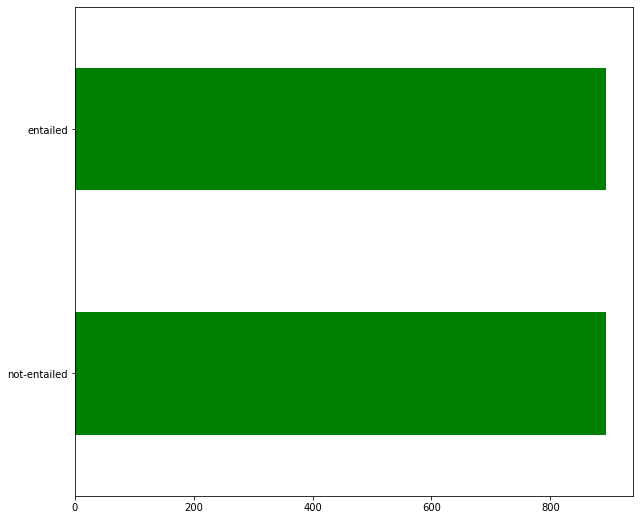

In [11]:
# Check
rnd_idx = np.random.randint(100)
part = "train"

display(pd.DataFrame(my_dataset_handler.tokenized_dataset[part][0:3]))
print(my_dataset_handler.tokenized_dataset)
print("Original Spans:", my_dataset_handler.dataset[part][rnd_idx])
print("Tokenized Spans:", my_dataset_handler.tokenized_dataset[part][rnd_idx])
test_tokens = tokenizer.convert_ids_to_tokens(my_dataset_handler.tokenized_dataset[part][rnd_idx]["input_ids"])
print(test_tokens)

s10, s11 = my_dataset_handler.tokenized_dataset[part][rnd_idx]["span1"][0], my_dataset_handler.tokenized_dataset[part][rnd_idx]["span1"][-1]
s20, s21 = my_dataset_handler.tokenized_dataset[part][rnd_idx]["span2"][0], my_dataset_handler.tokenized_dataset[part][rnd_idx]["span2"][-1]
print("span1:", s10, s11, test_tokens[s10:s11])
print("span2:", s20, s21, test_tokens[s20:s21])
print("label:", my_dataset_handler.tokenized_dataset[part][rnd_idx]["label"])

pd.DataFrame(my_dataset_handler.tokenized_dataset[part]["label"], columns=['label'])["label"].value_counts().plot(kind='barh', color="green", figsize=(10, 9));

# Edge Probe

In [12]:
class SpanRepr(ABC, nn.Module):
    """Abstract class describing span representation."""

    def __init__(self, input_dim, use_proj=False, proj_dim=256):
        super(SpanRepr, self).__init__()
        self.input_dim = input_dim
        self.proj_dim = proj_dim
        self.use_proj = use_proj

    @abstractmethod
    def forward(self, spans, attention_mask):
        raise NotImplementedError

    def get_input_dim(self):
        return self.input_dim

    @abstractmethod
    def get_output_dim(self):
        raise NotImplementedError

class MaxSpanRepr(SpanRepr, nn.Module):
    """Class implementing the max-pool span representation."""

    def forward(self, spans, attention_mask):
        """ 
        input:
            spans: [batch_size, layers, span_max_len, proj_dim/embedding_dim] ~ [32, 13, 4, 256]
            attention_mask: [batch_size, span_max_len] ~ [32, 4]
        """
        # TODO: Vectorize this
        for i in range(len(attention_mask)):
            for j in range(len(attention_mask[i])):
                if attention_mask[i][j] == 0:
                    spans[i, :, j, :] = -1e10

        # print(spans[0])
        max_span_repr, max_idxs = torch.max(spans, dim=-2)
        # print(max_span_repr.shape)
        return max_span_repr

    def get_output_dim(self):
        if self.use_proj:
            return self.proj_dim
        else:
            return self.input_dim

def get_span_module(input_dim, method="max", use_proj=False, proj_dim=256):
    """Initializes the appropriate span representation class and returns the object.
    """
    if method == "avg":
        return AvgSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "max":
        return MaxSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "diff":
        return DiffSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "diff_sum":
        return DiffSumSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "endpoint":
        return EndPointRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "coherent":
        return CoherentSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "coherent_original":
        return CoherentOrigSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "attn":
        return AttnSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "coref":
        return AttnSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim, use_endpoints=True)
    else:
        raise NotImplementedError

In [13]:
class Edge_probe_model(nn.Module):
    def __init__(self, num_layers, input_span_len, embedding_dim, num_classes, pool_method='max', use_proj=True, proj_dim=256, hidden_dim=256, device='cuda'):
        super(Edge_probe_model, self).__init__()
        self.device = device
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.weighing_params = nn.Parameter(torch.ones(self.num_layers))
        self.input_dim = 2 * embedding_dim
        if use_proj:
            # Apply a projection layer to output of pretrained models
            print(embedding_dim, num_layers, proj_dim)
            self.proj1 = nn.Linear(embedding_dim, proj_dim)
            self.proj2 = nn.Linear(embedding_dim, proj_dim)
            # Update the input_dim
            self.input_dim = 2 * proj_dim
        else:
            self.proj1 = None

        self.span1_pooling_net = get_span_module(embedding_dim)
        self.span2_pooling_net = get_span_module(embedding_dim)

        self.label_net = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.Tanh(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, self.num_classes),
            nn.Sigmoid()
        )
        self.training_criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=5e-4, weight_decay=0)

    def forward(self, spans_torch_dict):
        span1_reprs = spans_torch_dict["span1"]
        span2_reprs = spans_torch_dict["span2"]
        span1_attention_mask = spans_torch_dict["span1_attention_mask"]
        span2_attention_mask = spans_torch_dict["span2_attention_mask"]
        # print(span1_reprs.shape)
        if self.proj1:
            span1_reprs = self.proj1(span1_reprs)
            span2_reprs = self.proj2(span2_reprs)
        
        pooled_span1 = self.span1_pooling_net(span1_reprs, span1_attention_mask)
        pooled_span2 = self.span2_pooling_net(span2_reprs, span2_attention_mask)
        
        output = torch.cat((pooled_span1, pooled_span2), dim=-1)
        # print(output.shape)  # torch.Size([32, 13, 512])

        wtd_encoded_repr = 0
        soft_weight = nn.functional.softmax(self.weighing_params, dim=0)
        for i in range(self.num_layers):
            wtd_encoded_repr += soft_weight[i] * output[:, i, :]
        # wtd_encoded_repr += soft_weight[-1] * encoded_layers[:, -1, :]
        output = wtd_encoded_repr

        pred_label = self.label_net(output)
        pred_label = torch.squeeze(pred_label, dim=-1)
        return pred_label

    def summary(self):
        print(self)
        pytorch_total_params = sum(p.numel() for p in self.parameters())
        pytorch_total_params_trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print("Total Parmaters:    ", pytorch_total_params)
        print("Trainable Parmaters:", pytorch_total_params_trainable)

In [17]:
class Edge_probe_trainer:
    # Public:
    def __init__(self, language_model, dataset_handler: Dataset_handler, verbose=True, device='cuda'):
        self.dataset_handler = dataset_handler
        self.language_model = language_model
        self.language_model.config.output_hidden_states = True
        self.device = device
        self.verbose = verbose
        def vprint(text):
            if verbose:
                print(datetime.datetime.now().time(), text)
        self.vprint = vprint

        self.current_hidden_states = None
        self.last_input_ids = None
        self.cached_hidden_states = {"input_ids": [], "hidden_states": []}

        self.vprint("Moving to device")
        self.language_model.to(self.device)
        num_layers, input_span_len, embedding_dim, num_classes = self.get_language_model_properties()
        self.MLP_device = "cpu"
        self.edge_probe_model = Edge_probe_model(
            num_layers = num_layers,
            input_span_len = input_span_len,
            embedding_dim = embedding_dim, 
            num_classes = num_classes,
            device = self.MLP_device
        )
        
    
    def train(self, batch_size, epochs=3):
        tokenized_dataset = self.dataset_handler.tokenized_dataset["train"]
        # self.edge_probe_model.to(self.device)
        self.edge_probe_model.to(self.MLP_device)
        self.vprint("Counting dataset rows")
        dataset_len = len(tokenized_dataset["input_ids"])
        # dataset_len = 60
        loss_history = {"train": [], "dev": [], "test": []}
        for epoch in range(epochs):
            running_loss = 0.0
            steps = 0
            # loss_history["train"].append(calc_loss(model, train_dataloader, device))
            # loss_history["dev"].append(calc_loss(model, dev_dataloader, device))
            # loss_history["test"].append(calc_loss(model, test_dataloader, device))
            self.print_stats(epoch)
            for i in tqdm(range(0, dataset_len, batch_size)):
                step = batch_size
                if i + batch_size > dataset_len:
                    step = dataset_len - i
                # print(f"WWW[{i}, {i+step})")
                
                spans_torch_dict = self.prepare_batch_data(tokenized_dataset, i, i + step, pad=True)
                labels = spans_torch_dict["one_hot_labels"]
                # zero the parameter gradients
                self.edge_probe_model.optimizer.zero_grad()
    
                # forward + backward + optimize
                # self.vprint("Forward MLP")
                outputs = self.edge_probe_model(spans_torch_dict)
                # self.vprint("Loss")
                loss = self.edge_probe_model.training_criterion(outputs, labels.float().to(self.MLP_device))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.edge_probe_model.parameters(), 5.0)
                self.edge_probe_model.optimizer.step()
                # self.vprint("Done")
    
                # print statistics
                running_loss += loss.item()
                steps += 1
                # print(f"loss: {running_loss / steps}")
            
            print(f"loss: {running_loss / steps}")

    # Private:
    def print_stats(self, epoch):
        if(epoch % 1 == 0):
            w = self.edge_probe_model.weighing_params.tolist()
            plt.bar(np.arange(len(w)), w)
            plt.ylabel('Weight')
            plt.xlabel('Layer');
            plt.show()

    def prepare_batch_data(self, tokenized_dataset, start_idx, end_idx, pad=False):
        # self.vprint("Extracting From Model")
        span_representations_dict = self.extract_embeddings(tokenized_dataset, start_idx, end_idx, pad=True)
        # self.vprint("To Device")
        span1_torch = torch.tensor(np.array(span_representations_dict["span1"])).float().to(self.MLP_device)  # (batch_size, #layers, max_span_len, embd_dim)
        span2_torch = torch.tensor(np.array(span_representations_dict["span2"])).float().to(self.MLP_device)
        span1_attention_mask_torch = torch.tensor(span_representations_dict["span1_attention_mask"])
        span2_attention_mask_torch = torch.tensor(span_representations_dict["span1_attention_mask"])
        one_hot_labels_torch = torch.tensor(span_representations_dict["one_hot_label"])
        # self.vprint("Done")
        spans_torch_dict = {"span1": span1_torch, 
                            "span2": span2_torch, 
                            "span1_attention_mask": span1_attention_mask_torch, 
                            "span2_attention_mask": span2_attention_mask_torch, 
                            "one_hot_labels": one_hot_labels_torch}
        return spans_torch_dict

    def get_language_model_properties(self):
        span_representations_dict = self.extract_embeddings(self.dataset_handler.tokenized_dataset["train"], 0, 10, pad=True)
        span1_torch = torch.tensor(span_representations_dict["span1"])
        num_layers = span1_torch[0].shape[0]
        span_len = span1_torch[0].shape[1]
        embedding_dim = span1_torch[0].shape[2]
        if self.verbose:
            display(pd.DataFrame(span_representations_dict).head())
        return num_layers, span_len, embedding_dim, len(self.dataset_handler.labels_list)

    def pad_span(self, span_repr, max_len):
        """ pad spans in embeddings to max_len 
        input:
            span_representation: df with shape (#layers, span_len, embedding_dim)
        returns:
            padded_spans: np with shape (batch_len, num_layers, max_len, embedding_dim)
            attention_mask: np with shape (max_len), values = 1: data, 0: padding
        """
        num_layers = span_repr.shape[0]
        span_original_len = span_repr.shape[1]
        embedding_dim = span_repr.shape[2]
        padded_span_repr = np.zeros((num_layers, max_len, embedding_dim))
        if span_original_len > max_len:
            raise Exception(f"Error: {span_original_len} is more than max_span_len {max_len}")
        attention_mask = np.array([1] * span_original_len + [0] * (max_len - span_original_len), dtype=np.int8)

        padded_span_repr = np.concatenate([span_repr, np.zeros((num_layers, max_len - span_original_len, embedding_dim))], axis=1)
        
        assert attention_mask.shape == (max_len, ), f"{attention_mask}, {attention_mask.shape} != ({max_len}, )"
        assert padded_span_repr.shape == (num_layers, max_len, embedding_dim)
        return padded_span_repr, attention_mask

    def init_span_dict(self, num_of_spans, pad):
        if num_of_spans == 2:
            span_repr = {"span1": [], "span2": [], "label": [], "one_hot_label": []}
        else:
            span_repr = {"span1": [], "label": [], "one_hot_label": []}
        
        if pad:
            span_repr["span1_attention_mask"] = []
            span_repr["span2_attention_mask"] = []
        return span_repr

    def extract_embeddings(self, tokenized_dataset, start_idx, end_idx, pad=False, cache=True):
        """ Extract raw embeddings for [start_idx, end_idx) of tokenized_dataset from language_model 
            
        Returns:
            extract_embeddings: DataFrame with cols (span1, span2?, label) and span shape is (range_len, (#layers, span_len, embedding_dim))
        """
        # tokenized_dataset = self.model_handler.tokenized_dataset
        max_span_len = self.dataset_handler.dataset_info.max_span_length
        num_of_spans = self.dataset_handler.dataset_info.num_of_spans

        span_repr = self.init_span_dict(num_of_spans, pad)
        
        unique_text_counter = 0
        for i in range(start_idx, end_idx):
            if self.last_input_ids != None and tokenized_dataset[i:i+1]["input_ids"] == self.last_input_ids:
                pass
            elif cache and tokenized_dataset[i:i+1]["input_ids"] in self.cached_hidden_states["input_ids"]:
                idx = self.cached_hidden_states["input_ids"].index(tokenized_dataset[i:i+1]["input_ids"])
                self.current_hidden_states = self.cached_hidden_states["hidden_states"][idx]
                self.last_input_ids = tokenized_dataset[i:i+1]["input_ids"]
            else:
                unique_text_counter += 1
                with torch.no_grad():
                    input_torch = torch.tensor(tokenized_dataset[i:i+1]["input_ids"]).to(self.device)
                    outputs = self.language_model(input_torch)
                    current_hidden_states = np.asarray([val.detach().cpu().numpy() for val in outputs.hidden_states])
                    self.current_hidden_states = current_hidden_states[:, 0]
                    self.last_input_ids = tokenized_dataset[i:i+1]["input_ids"]
                    if not self.last_input_ids in self.cached_hidden_states["input_ids"]:
                        self.cached_hidden_states["input_ids"].append(self.last_input_ids)
                        self.cached_hidden_states["hidden_states"].append(self.current_hidden_states)

            row = tokenized_dataset[i]
            span1_hidden_states = self.current_hidden_states[:, row["span1"][0]:row["span1"][1], :]  # (#layer, span_len, embd_dim)
            if pad:
                s1, a1 = self.pad_span(np.array(span1_hidden_states), max_span_len)
                span_repr["span1"].append(s1)
                span_repr["span1_attention_mask"].append(a1)
            else:
                span_repr["span1"].append(np.array(span1_hidden_states))

            if num_of_spans == 2:
                span2_hidden_states = self.current_hidden_states[:, row["span2"][0]:row["span2"][1], :]
                if pad:
                    s2, a2 = self.pad_span(np.array(span1_hidden_states), max_span_len)
                    span_repr["span2"].append(s2)
                    span_repr["span2_attention_mask"].append(a2)
                else:
                    span_repr["span2"].append(np.array(span2_hidden_states))
            
            span_repr["one_hot_label"].append(row["one_hot_label"])
            span_repr["label"].append(row["label"])

        # vprint(f"{unique_text_counter} unique texts")
        return span_repr

        
        

In [18]:
my_edge_probe_trainer = Edge_probe_trainer(model, my_dataset_handler, device=DEVICE)

08:25:09.452371 Moving to device


,span1,span2,label,one_hot_label,span1_attention_mask,span2_attention_mask
0,"[[[-1.2370696067810059, 0.6256345510482788, -1...","[[[-1.2370696067810059, 0.6256345510482788, -1...",not-entailed,"[1, 0]","[1, 0, 0]","[1, 0, 0]"
1,"[[[-1.2370696067810059, 0.6256345510482788, -1...","[[[-1.2370696067810059, 0.6256345510482788, -1...",entailed,"[0, 1]","[1, 0, 0]","[1, 0, 0]"
2,"[[[-1.2370696067810059, 0.6256345510482788, -1...","[[[-1.2370696067810059, 0.6256345510482788, -1...",entailed,"[0, 1]","[1, 0, 0]","[1, 0, 0]"
3,"[[[-1.2370696067810059, 0.6256345510482788, -1...","[[[-1.2370696067810059, 0.6256345510482788, -1...",not-entailed,"[1, 0]","[1, 0, 0]","[1, 0, 0]"
4,"[[[-0.654297411441803, 0.46990516781806946, 0....","[[[-0.654297411441803, 0.46990516781806946, 0....",entailed,"[0, 1]","[1, 0, 0]","[1, 0, 0]"


768 13 256


08:25:12.092726 Counting dataset rows


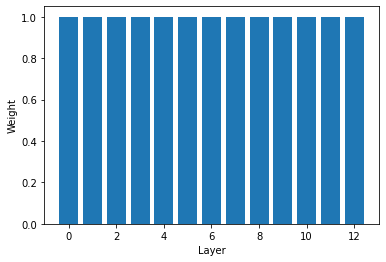


loss: 0.726843918540648


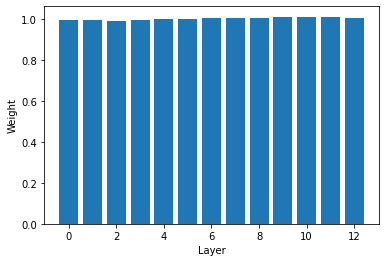


loss: 0.7020747379532882


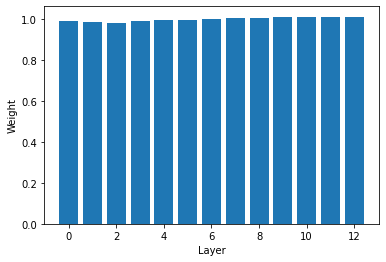


loss: 0.7027324565819332


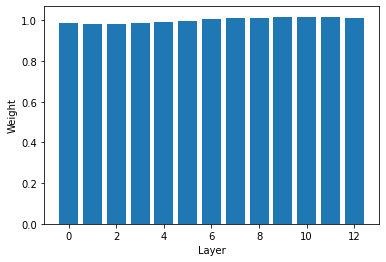


loss: 0.7022139217172351


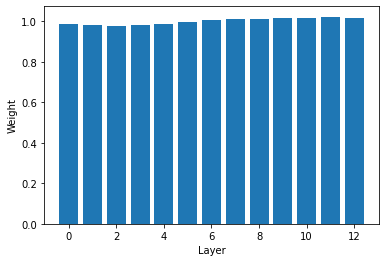


loss: 0.6988007718963283


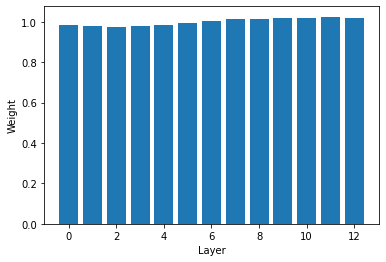


loss: 0.69773332881076


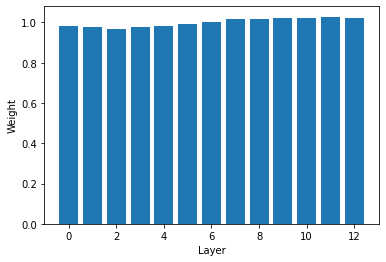


loss: 0.6969304904341698


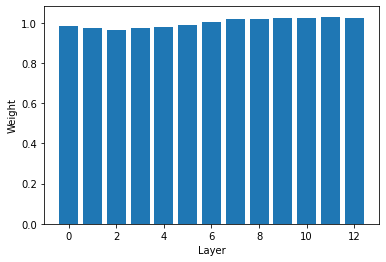


loss: 0.7021381525056702


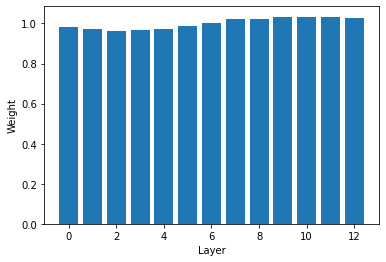


loss: 0.7002020095075879


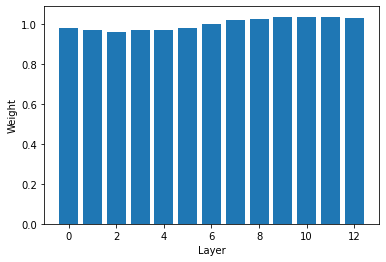


loss: 0.6976070765938077


In [19]:
my_edge_probe_trainer.train(batch_size = 16, epochs=10)

In [ ]:
# TODO: Cache BERT predictions as much as RAM allows